# Etienne's Idea for Differentiable Shapes!

## Imports

In [398]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# cassetta <3
import cassetta
from cassetta.losses.segmentation import DiceLoss
from cassetta.models.segmentation import SegNet

## Soft Quantize Helper Function
This is a big part of the whole differentiable shapes idea. In making the PyTorch
arm of *Adrian's Neurite project*, I came across this soft quantize function. This one in particular, I coded, but I think it's overall loosely based on his. I
think softly quantizing is pretty standard, but this is what made me put two and two together to come up with this hypothesized method.

In [424]:
def soft_quantize(
    input_tensor: torch.Tensor,
    nb_bins: int = 16,
    softness: float = 1.0,
    min_clip: float = -float('inf'),
    max_clip: float = float('inf'),
    return_log: bool = False,
    bin_centers: list = None
) -> torch.Tensor:
    """
    This function softly maps continuous values to discrete bins while retaining smoothness,
    controlled by the `softness` parameter.

    This function is used to discretize continuous values into bins while preserving some continuity
    or smoothness in the data. It is especially useful in the context of machine learning, where it
    is desirable to have a differentiable version of a quantized quantity, allowing for backprop.
    Hard quantization is non-differentiable and creates gradients of zero, making gradient-based
    optimization impossible.

    Parameters
    ----------
    input_tensor : torch.Tensor
        Input tensor to softly quantize.
    nb_bins : int, optional
        The number of discrete bins to softly quantize the input values into. By default 16
    softness : float, optional
        The softness factor for quantization. A higher value gives smoother quantization.
        By default 1.0
    min_clip : float, optional
        Clip data lower than this value before calculating bin centers. By default -float('inf')
    max_clip : float, optional
        Clip data higher than this value before calculating bin centers. By default float('inf')
    return_log : bool, optional
        Optionally return the log of the softly quantized tensor. By default False

    Returns
    -------
    torch.Tensor
        Softly quantized tensor with the same dimensions as `input_tensor`.

    Examples
    --------
    >>> import torch
    >>> import matplotlib.pyplot as plt
    # Make a random 3D tensor with zero mean and unit variance.
    >>> input_tensor = torch.randn(1, 1, 32, 32, 32)
    # Compute the softly quantized tensor with a low softness to approximate (and visualize) a
    # pseudo-hard quantization.
    >>> softly_quantized_tensor = soft_quantize(input_tensor, nb_bins=4, softness=0.5)
    # Visualize the softly quantized tensor.
    >>> plt.imshow(softly_quantized_tensor[0, 0, 16])
    """
    # Invert softness
    softness = 1 / softness

    # Optionally clip `input_tensor`
    # input_tensor.clip_(min_clip, max_clip)
    if bin_centers is None:
        # Get the bin centers
        bin_centers = torch.linspace(
            start=input_tensor.min(),
            end=input_tensor.max(),
            steps=nb_bins,
            device=input_tensor.device
        )

    # Compute the distance between each element in `input_tensor` and the centers of the bins.
    # The resultant has `nb_bins` channels in the last dimension, each corresponding to the distance
    # between that element's intensity (in pixel/voxel space) to the center of each of the bins.
    distances_to_bin_centers = torch.abs(input_tensor.unsqueeze(-1) - bin_centers)

    # Apply softmax along last dimension
    softly_quantized = F.softmax(-softness * distances_to_bin_centers, dim=-1)

    # Compute the softly quantized value by averaging bin centers weighted by softmax values
    softly_quantized = (softly_quantized * bin_centers).sum(dim=-1)

    # Optionally convert to log domain
    if return_log:
        softly_quantized.log_()
    return softly_quantized


# Defining the meshgrid
It starts with the standard protocol from the base of my SynthShapes project,
where I generate a meshgrid whose origin is the center of the shape that I am generating. This will allow us to later define a distance from the center that we want to keep when defining the boundaries of the blob

tensor([-64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53, -52, -51,
        -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37,
        -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23,
        -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,
         -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
         20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
         34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63], device='cuda:0')


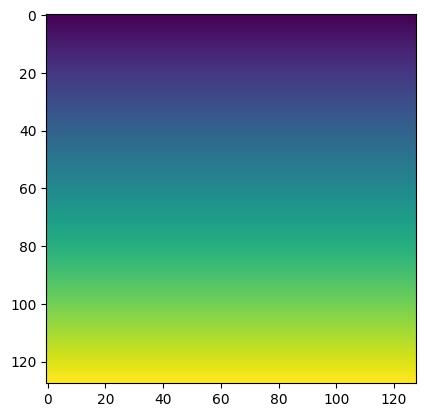

In [408]:
# Just going to define the device first
device = 'cuda'
# Shape of the entire image/volume tensor to be generated.
output_shape = (128, 128, 128)

# Position of the blob in the tensor (when origins are set to zero) we will be
# shifting the entire meshgrid to make this point in space the origin
center_coords = (64, 64, 64)

# Defining the meshgrid!
# For each axis, we just set the upper bound to be the size of the entire
# output image/volume in that dimension, and make the domain corresponding to
# each point on the axis number line thing. We then "zero" it out by
# subtracting the center coordinate.
meshgrid = torch.meshgrid(
    # X axis
    torch.arange(output_shape[0], device=device) - center_coords[0],
    # Y axis
    torch.arange(output_shape[1], device=device) - center_coords[1],
    # Z axis
    torch.arange(output_shape[2], device=device) - center_coords[2],
    indexing='ij'
    )
# Let's just see what this looks like
print(torch.unique(meshgrid[0]))
# Let's a look at a plane in XZ
plt.imshow(meshgrid[0][:, 64].cpu())

In [414]:
# Some parameters for the geometry of the blob
jitter = 1
sharpness = 2
axis_lengths = (10, 10, 10)

# Modifying the meshgrid
I view this meshgrid as the inverse probability (it's not normalized, of course) of voxels belonging to a particular shape. The lowest value (being zero) is the origin, so it's definately part of the shape. The neighboring voxels in any direction equal 1, so they're almost certaintly part of the shape, and we keep radiating outward until we hit the `axis_lengths` distance from the origin for each dimension. If we were to stop here, every single point in space that is 10 voxels from the center would be part of the shape, but in the next step we will add some noise to it to jitter the field and make it less rigid.

True


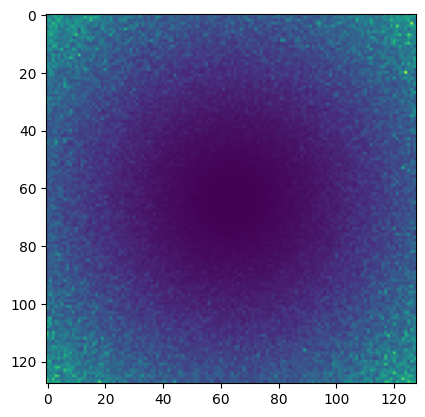

In [ ]:
# We _could_ just take all voxels that are equal to or less than, say 10,
# and call that the blob, but let's be more creative. let's make some noise
# in the distance map so our blobs aren't perfectly defined circles or shapes.
noise = torch.normal(
    0,
    jitter,
    size=[
        output_shape[0],
        output_shape[1],
        output_shape[2]
        ],
    device=device
)

# From each axis, we will divide the meshgrid by the axis length, to define our
# shape boundary, such that the values of the mesh grid less than 1
# (distance to center = axis length) constitute part of the shape. 
# Remember, we added noise to the distance map, so it _won't_ be a perfect
# shape.
lobe_prob = (
    torch.abs(
        meshgrid[0] / (axis_lengths[0] + noise)
        ) ** sharpness +
    torch.abs(meshgrid[1] / (axis_lengths[1] + noise)
        ) ** sharpness +
    torch.abs(meshgrid[2] / (axis_lengths[2] + noise)
        ) ** sharpness
    )

# Make the (inverse) prob field require grad
# Up until now, I don't think we really care about how this distance field is
# made, but we will definately want to track the gradients from here on out,
# as we will soft quantize and define our (soft) label map!
lobe_prob.requires_grad_()
print(lobe_prob.requires_grad)

plt.imshow(lobe_prob[64].cpu().detach())

# Softly quantize!
Now, we will softly quantize the field! Originally, I just did a hard threshold at 1, but why not do it softly to make it differentiable??

True


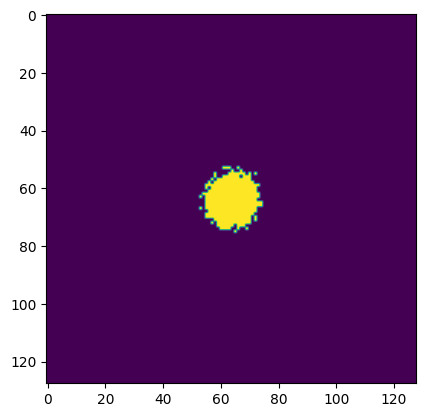

In [ ]:
# Soft quantize
# Again, all voxels that constitute the shape are ~less than or equal to 1,
# So we will make our bin centers stradle this.
bin_centers = torch.Tensor([0.0000, 2.0000]).cuda()
soft_binary_mask = soft_quantize(
    abs(lobe_prob),
    softness=1e-5,
    bin_centers=bin_centers
)

# Invert because we want the mask to be labels for the blob, not the inverse.
soft_binary_mask = 1 - soft_binary_mask

# Reshape with B & C dims to pass through model later
soft_binary_mask = soft_binary_mask.unsqueeze(0).unsqueeze(0)
# Let's make sure it still requires gradient (and is differentiable)
print(soft_binary_mask.requires_grad)
# Let's look at it!
plt.imshow(soft_binary_mask[0, 0, 64].cpu().detach())

# Seeing if we can backprop

Now we will just define a model and pass our soft_binary_mask mask through it (why not?) and compute the dice with the output. We will then backprop to see
if this is feasable for making differentiable shapes

In [ ]:
model = SegNet(3, 1, 1).cuda()

# Sample labels with requires_grad=True to make them differentiable

# Check if labels are differentiable
print("Labels require grad:", soft_binary_mask.requires_grad)

output = model(soft_binary_mask)

loss = DiceLoss()(output, soft_binary_mask)

# Does it work?
loss.backward()
print('It does!')

Labels require grad: True
It does!


# Semantic labels?
I was also thinking we can use this for semantic segmentation of the EPVS/vessel
sheaths. What do you think?

True


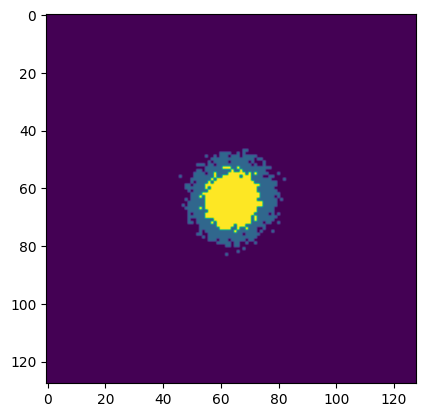

In [423]:
# Soft quantize
# Again, all voxels that constitute the shape are ~less than or equal to 1,
# So we will make our bin centers stradle this.
bin_centers = torch.Tensor([0.0000, 2.0000, 3.0000]).cuda()
soft_binary_mask = soft_quantize(
    abs(lobe_prob),
    softness=1e-5,
    bin_centers=bin_centers
)

# Invert because we want the mask to be labels for the blob, not the inverse.
soft_binary_mask = 1 - soft_binary_mask

# Reshape with B & C dims to pass through model later
soft_binary_mask = soft_binary_mask.unsqueeze(0).unsqueeze(0)
print(soft_binary_mask.requires_grad)
plt.imshow(soft_binary_mask[0, 0, 64].cpu().detach())